In [1]:

import seaborn as sns
import pandas as pd
import numpy as np
import math

import os

import matplotlib.pyplot as plt



In [2]:
import numpy as np

def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=8):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3

    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))


In [3]:
def b_transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - math.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(var, kb )

    return num_ind

def model(x, beta, gamma, N):

    S   = x[0]   # Susceptibles
    I   = x[1]   # Infected Reported
    R   = x[2]   # Recovered

    foi =  beta * (I) / N

    # Stochastic transitions
    s2i     =  b_transition(S, foi)                 # susceptible to exposed
    i2r     =  b_transition(I, gamma) # exposed to infected reported who are not going to die

    # Updates
    S    = S   - s2i      # Susceptible
    I    = I   + s2i - i2r      # Infected reported
    R    = R   + i2r      # Recovered
    C    = s2i

    return [S, I, R, C]

In [4]:
R0    = 3
gamma = 1/7
beta  = R0*gamma
N     = 1e8

beta_truth  = beta
gamma_truth = gamma

num_days = 100
x  = [N-0.01*N, 0.01*N, 0, 0.01*N]

x_sol      = np.zeros((num_days, 4))

x_sol[0, :] = x
for d_idx in range(1, num_days):
    x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta, gamma, N)

x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"

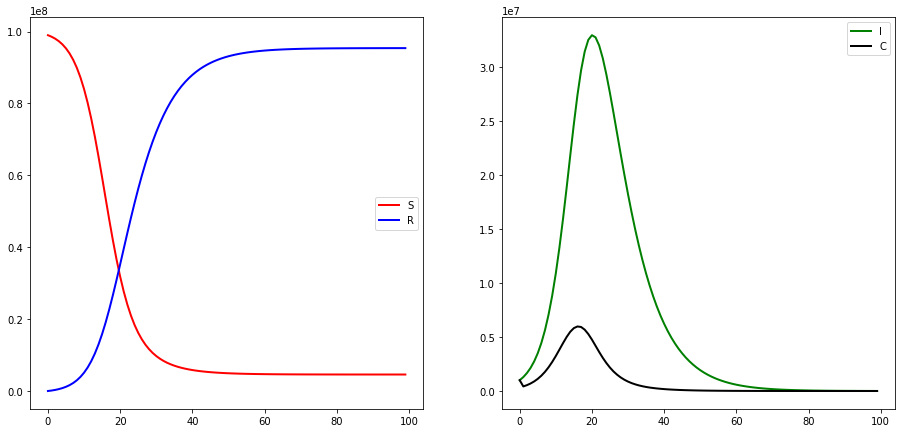

In [5]:

fig, ax = plt.subplots(1, 2, figsize=(15.5, 7.2))
ax[0].plot(x_sol_df.index.values, x_sol_df["S"], lw=2, c="r", label="S")
ax[0].plot(x_sol_df.index.values, x_sol_df["R"], lw=2, c="b", label="R")

ax[1].plot(x_sol_df.index.values, x_sol_df["I"], lw=2, c="g", label="I")
ax[1].plot(x_sol_df.index.values, x_sol_df["C"], lw=2, c="k", label="C")
ax[0].legend()
ax[1].legend()


In [6]:
from scipy.stats import truncnorm
import numpy as np


def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response


In [7]:
import numpy as np




def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=4):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3


    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))


In [8]:
obs_df    = x_sol_df[["C"]].rename(columns={"C": "confirmed"})
obs_df

,confirmed
date,
0,1000000.0
1,422420.0
2,542577.0
3,694107.0
4,886534.0
...,...
95,206.0
96,174.0
97,156.0


In [16]:
oev_df

,oev
date,
0,6.400000e+11
1,1.142007e+11
2,1.884095e+11
3,3.083421e+11
4,5.030032e+11
...,...
95,2.716004e+04
96,1.937764e+04
97,1.557604e+04


In [17]:

priors_range_dict  = {}
priors_range_dict["beta"]  = [0.3, 1] # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3]  # Recovery rate range


lambda_inf    = 1.01
num_params    = 2
num_iters_mif = 60
alpha_mif     = 0.9 # Variance shrinking factor
num_ensembles = 300

obs_df    = x_sol_df[["C"]].rename(columns={"C": "confirmed"})

oev_df         = pd.DataFrame(columns=["date", "oev"])
oev_df["date"] = obs_df.index.values
oev_df         = oev_df.set_index("date")

oev_df["oev"] = np.maximum(2e6,  1+(0.8*obs_df["confirmed"].values)**2  )


######## INFERENCE  SETTINGS ########
# Range of parameters
param_range = np.array([v for k, v in priors_range_dict.items()])
std_param   = param_range[:,1]-param_range[:,0]
SIG         = std_param ** 2 / 4; #  initial covariance of parameters

num_steps     = len(obs_df) #387
para_post_all = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
theta         = np.zeros((num_params, num_iters_mif+1))

confirmed_post_all = np.zeros((1, num_ensembles, num_steps, num_iters_mif))
deaths_post_all   = np.zeros((1, num_ensembles, num_steps, num_iters_mif))

para_post_all = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
x_post_all    = np.zeros((4, num_ensembles, num_steps, num_iters_mif))
theta         = np.zeros((num_params, num_iters_mif+1))

dates_assimilation = obs_df.index.get_level_values(0).values
dates = dates_assimilation

################################################

In [18]:
from tqdm import tqdm

print(f"Running MIF  \n")
for n in tqdm(range(num_iters_mif)):
    if n==0:
        p_prior     = sample_params_uniform(priors_range_dict, num_ensembles=num_ensembles)
        beta        = p_prior[0,:]
        gamma       = p_prior[1,:]
        x           = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, num_ensembles))
        theta[:, n] = np.mean(p_prior, -1)

    else:
        params_mean     = theta[:,n]
        params_var      = SIG * (alpha_mif**n)**2
        p_prior         = sample_params_normal(priors_range_dict, params_mean, params_var, num_ensembles=num_ensembles)
        beta            = p_prior[0,:]
        gamma           = p_prior[1,:]
        x               = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, num_ensembles))

    param_post_time   = np.zeros((len(priors_range_dict), num_ensembles, num_steps))
    x_post_time       = np.zeros((4, num_ensembles, num_steps))

    cases_post_time   = np.zeros((1, num_ensembles, num_steps))
    deaths_post_time  = np.zeros((1, num_ensembles, num_steps))

    idx_date_update = 0


    cases_t = np.zeros((num_ensembles, 1))
    deaths_t = np.zeros((num_ensembles, 1))

    confirmed_t = np.zeros((num_ensembles, 1))
    deaths_t    = np.zeros((num_ensembles, 1))

    for idx_t, date in enumerate(dates):

        #infalte state variables
        x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=300)
        x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=x.shape[0], num_ensembles=300)

        #inflate parameters
        p_prior = inflate_ensembles(p_prior, inflation_value=lambda_inf)
        p_prior = checkbound_params(priors_range_dict, p_prior, num_ensembles=300)

        x_ens =[]
        for idx_ens in range(num_ensembles):
            beta   = p_prior[0, idx_ens]
            gamma  = p_prior[1, idx_ens]

            x_ens.append(model(x[:,idx_ens], beta, gamma, N))

        x_ens = np.array(x_ens).T
        x = x_ens

        confirmed_t  +=  np.expand_dims(x[-1,:], -1)

        if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[idx_date_update]):

                oev_confirmed_time = oev_df.loc[date]["oev"]

                confirmed_time = obs_df.loc[date]["confirmed"]

                param_post = p_prior.copy()
                # Update parameters using confirmed deaths
                x_post, param_post, confirmed_obs_post = eakf_step(x, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, priors_range_dict)
                x_post                              = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=x.shape[0], num_ensembles=300)
                param_post                          = checkbound_params(priors_range_dict, params_ens=param_post, num_ensembles=300)

                x = x_post
                # Use posterior and next prior
                p_prior = param_post.copy()

                cases_post_time[:,:,idx_date_update]  = confirmed_obs_post
                param_post_time[:,:,idx_date_update]  = param_post
                x_post_time[:,:,idx_date_update]      = x_post

                idx_date_update += 1

                confirmed_t = np.zeros((num_ensembles, 1))

    confirmed_post_all[:,:,:,n] = cases_post_time
    para_post_all[:,:,:,n]      = param_post_time
    x_post_all[:,:,:,n]         = x_post_time
    theta[:,n+1]                = param_post_time.mean(-1).mean(-1)


  0%|          | 0/60 [00:00<?, ?it/s]

Running MIF  



100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


In [19]:
para_post_all.shape

para_post_iter = para_post_all.mean(2)
para_post_iter.shape

(2, 300, 60)

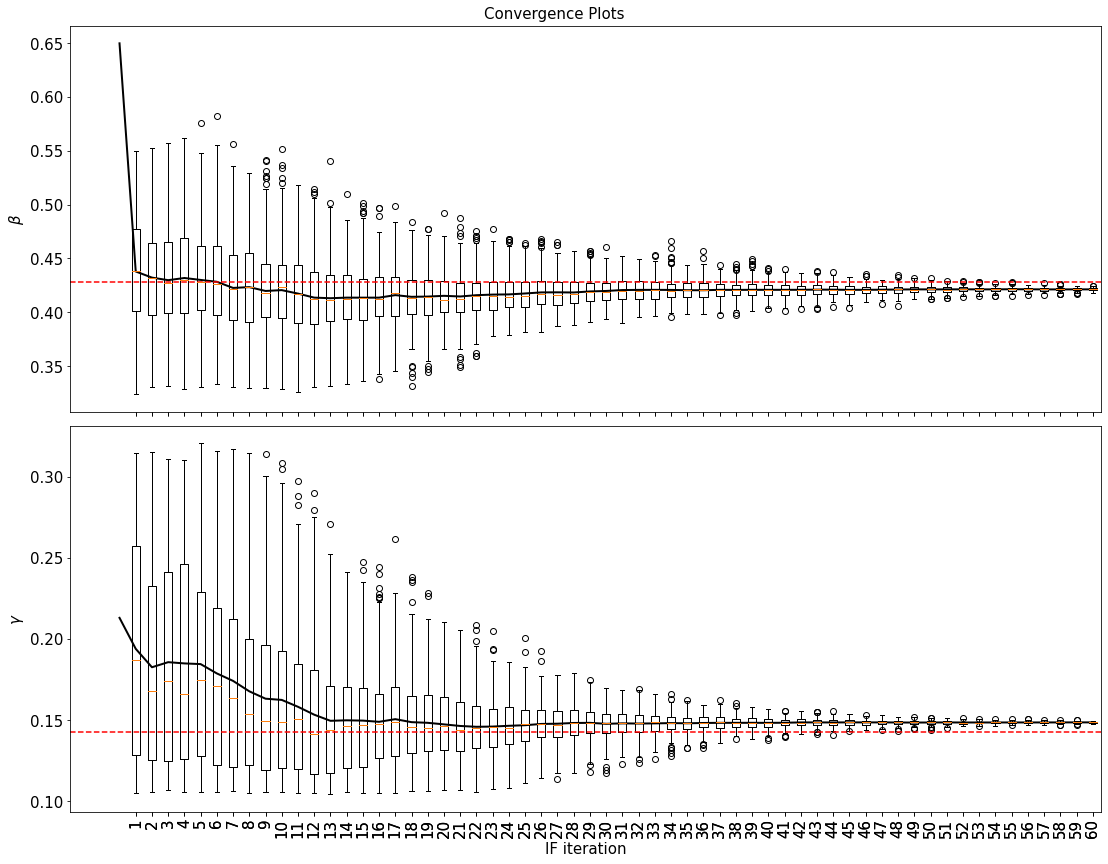

In [20]:
import seaborn as sns
# Convergence Plots
fig, ax = plt.subplots(2, 1, figsize=(15.5, 12.2), sharex=True)
ax[0].boxplot(para_post_iter[0,:,:])
ax[0].plot(range(num_iters_mif+1), theta[0,:], color="k", lw=2)
ax[0].axhline(y=beta_truth, color="red", linestyle="--")

ax[1].boxplot(para_post_iter[1, :, :])
ax[1].plot(range(num_iters_mif+1), theta[1,:], color="k", lw=2)
ax[1].axhline(y=gamma_truth, color="red", linestyle="--")

ax[0].set_ylabel(r"$\beta$", fontsize=15)
ax[1].set_ylabel(r"$\gamma$", fontsize=15)

for axi in ax:
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)

ax[1].set_xlabel("IF iteration", fontsize=15)
fig.suptitle("Convergence Plots", fontsize=15)
plt.tight_layout()

In [44]:
import datetime

confirmed_time_fitted = np.mean(confirmed_post_all[:,:,:,9:20],-1)
df_confirmed = create_df_response(np.squeeze(confirmed_time_fitted), time=num_steps)
df_confirmed

,mean,median,std,low_50,high_50,low_80,high_80,low_95,high_95,type
date,,,,,,,,,,
2020-03-06,431035.394326,428754.864650,21949.314878,415939.132459,4.471577e+05,405317.876608,4.592850e+05,392724.054520,4.756716e+05,estimate
2020-03-07,539078.385440,533363.839110,35950.825991,514297.832826,5.658193e+05,496261.389967,5.847106e+05,477752.023315,6.138105e+05,estimate
2020-03-08,665273.641791,656980.480339,52429.028477,629447.786897,7.021172e+05,605535.921760,7.328025e+05,576332.249641,7.739109e+05,estimate
2020-03-09,815569.462792,805386.868068,70951.010674,767005.886465,8.664289e+05,733591.260108,9.076027e+05,697730.715699,9.590410e+05,estimate
2020-03-10,997512.349490,986247.568647,91872.144435,935486.863878,1.062508e+06,889895.842905,1.116686e+06,847205.839782,1.181085e+06,estimate
...,...,...,...,...,...,...,...,...,...,...
2020-06-09,99.631160,97.294440,35.492520,73.467796,1.196414e+02,60.786250,1.431314e+02,41.482651,1.763373e+02,estimate
2020-06-10,86.661607,84.048055,31.773812,62.366962,1.059074e+02,51.495066,1.276597e+02,33.928906,1.578012e+02,estimate
2020-06-11,75.668658,73.301078,28.470988,54.798573,9.268512e+01,42.935071,1.113459e+02,29.622846,1.358140e+02,estimate


Text(0.5, 44.7, 'Date')

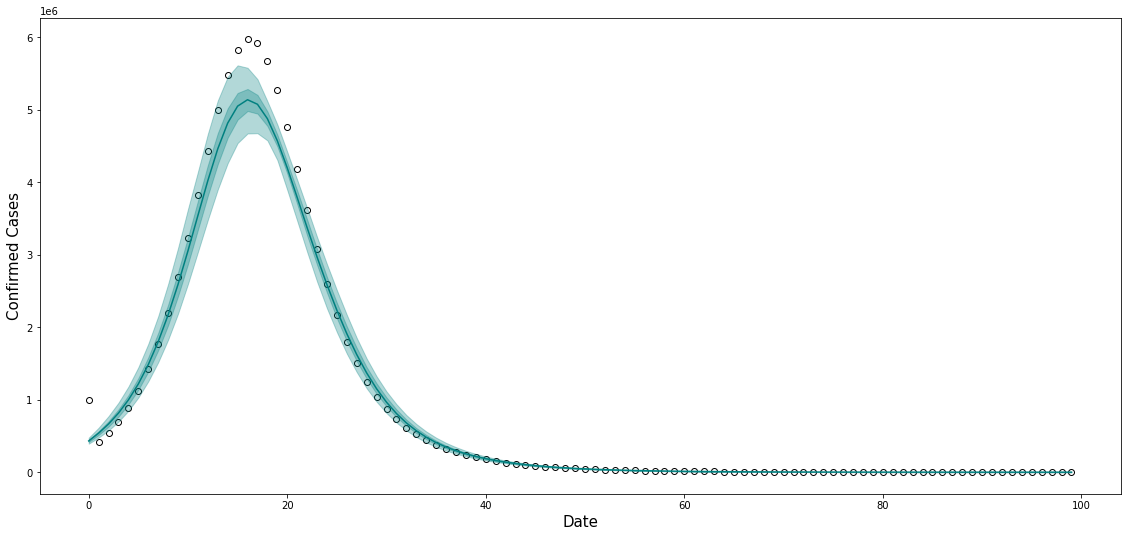

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.3))

ax.scatter(obs_df.index.values, obs_df.confirmed, facecolor="white", edgecolor="k")
ax.plot(obs_df.index.values[:num_steps], df_confirmed["mean"], color="teal")
ax.fill_between(obs_df.index.values[:num_steps], df_confirmed["low_95"], df_confirmed["high_95"], color="teal", alpha=0.3)
ax.fill_between(obs_df.index.values[:num_steps], df_confirmed["low_50"], df_confirmed["high_50"], color="teal", alpha=0.3)
plt.tight_layout()

ax.set_ylabel("Confirmed Cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)


In [83]:
def poisson_likelihood(real_world_observations, model_observations, num_times):
    nll = np.sum(model_observations,1)-np.sum(real_world_observations*np.log(model_observations),1) #Poisson ML
    return nll


# Monte Carlo Profile Confidence Intervals for Dynamic Systems
    E Ionides, C. Breto, J Park, R. A. Smith, A. A. King

In [47]:
priors_range_dict  = {}
priors_range_dict["beta"]  = [0.3, 1] # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3]  # Recovery rate range

beta_search = np.arange(priors_range_dict["beta"][0], priors_range_dict["beta"][1], 0.1)
gamma       = 1/7

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

7

In [94]:
# Compute log-likelihood using EAKF
num_particles = 1000

beta_ll = np.full((beta_search.shape[0], num_particles), np.nan)

for idx_beta, beta in tqdm(enumerate(beta_search)):
    p_likelihood  = np.array([[beta],[gamma]]) * np.ones((2, num_particles))
    x             = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, num_particles))

    param_post_time   = np.zeros((len(priors_range_dict), num_particles, num_steps))
    x_post_time       = np.zeros((4, num_particles, num_steps))

    cases_post_time   = np.zeros((1, num_particles, num_steps))
    deaths_post_time  = np.zeros((1, num_particles, num_steps))

    idx_date_update = 0


    cases_t = np.zeros((num_particles, 1))
    confirmed_t = np.zeros((num_particles, 1))

    for idx_t, date in enumerate(dates):

        #infalte state variables
        x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=num_particles)
        x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=x.shape[0], num_ensembles=num_particles)

        #inflate parameters
        p_likelihood = inflate_ensembles(p_likelihood, inflation_value=lambda_inf, num_ensembles=num_particles)
        p_likelihood = checkbound_params(priors_range_dict, p_likelihood, num_ensembles=num_particles)

        x_ens =[]
        for idx_ens in range(num_particles):
            beta   = p_likelihood[0, idx_ens]
            gamma  = p_likelihood[1, idx_ens]

            x_ens.append(model(x[:,idx_ens], beta, gamma, N))

        x_ens = np.array(x_ens).T
        x = x_ens

        confirmed_t  +=  np.expand_dims(x[-1,:], -1)


        oev_confirmed_time = oev_df.loc[date]["oev"]

        confirmed_time = obs_df.loc[date]["confirmed"]

        param_post = p_likelihood.copy()
        # Update parameters using confirmed deaths
        x_post, param_post, confirmed_obs_post = eakf_step(x, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, priors_range_dict)
        x_post                              = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=x.shape[0], num_ensembles=num_particles)
        param_post                          = checkbound_params(priors_range_dict, params_ens=param_post, num_ensembles=num_particles)

        x = x_post
        # Use posterior and next prior
        p_likelihood = param_post.copy()

        cases_post_time[:,:,idx_t]  = confirmed_obs_post
        param_post_time[:,:,idx_t]  = param_post
        x_post_time[:,:,idx_t]      = x_post

        confirmed_t = np.zeros((num_particles, 1))
    beta_ll[idx_beta,:] = poisson_likelihood(obs_df["confirmed"].values, np.squeeze(cases_post_time), num_times=100)


In [91]:
    ll = poisson_likelihood(obs_df["confirmed"].values, np.squeeze(cases_post_time), num_times=100)
ll.shape

(1000,)

In [46]:
# Monte Carlo Adjusted Profile

##' Monte Carlo adjusted profilzzze
##'
##' Given a collection of points maximizing the likelihood over a range
##' of fixed values of a focal parameter, this function constructs
##' a profile likelihood confidence interval accommodating both
##' Monte Carlo error in the profile and statistical uncertainty present
##' in the likelihood function.
##'
##' @importFrom stats lm loess predict qchisq vcov
##' @param lp a vector of profile likelihood evaluations.
##' @param parameter the corresponding values of the focal parameter.
##' @param confidence the required level of the confidence interval.
##' @param lambda the loess parameter used to smooth the profile.
##' @param Ngrid the number of points to evaluate the smoothed profile.
##' @return \code{mcap()} returns a list including the smoothed profile,
##' a quadratic approximation, and the constructed confidence interval.
##' @author Edward L. Ionides
##' @export
##'

mcap <- function(lp,parameter,confidence=0.95,lambda=1,Ngrid=1000){
  smooth_fit <- loess(lp ~ parameter,span=lambda)
  parameter_grid <- seq(min(parameter), max(parameter), length.out = Ngrid)
  smoothed_loglik <- predict(smooth_fit,newdata=parameter_grid)
  smooth_arg_max <- parameter_grid[which.max(smoothed_loglik)]
  dist <- abs(parameter-smooth_arg_max)
  included <- dist < sort(dist)[trunc(lambda*length(dist))]
  maxdist <- max(dist[included])
  weights <- rep(0,length(parameter))
  weights[included] <- (1-(dist[included]/maxdist)^3)^3
  quadratic_fit <- lm(lp ~ a + b, weights=weights,
                      data = data.frame(lp=lp,b=parameter,a=-parameter^2)
  )
  b <- unname(coef(quadratic_fit)["b"] )
  a <- unname(coef(quadratic_fit)["a"] )
  m <- vcov(quadratic_fit)
  var_b <- m["b","b"]
  var_a <- m["a","a"]
  cov_ab <- m["a","b"]
  se_mc_squared <- (1 / (4 * a^2)) * (var_b - (2 * b/a) * cov_ab + (b^2 / a^2) * var_a)
  se_stat_squared <- 1/(2*a)
  se_total_squared <- se_mc_squared + se_stat_squared
  delta <- qchisq(confidence,df=1) * ( a * se_mc_squared + 0.5)
  loglik_diff <- max(smoothed_loglik) - smoothed_loglik
  ci <- range(parameter_grid[loglik_diff < delta])
  list(lp=lp,parameter=parameter,confidence=confidence,
       quadratic_fit=quadratic_fit, quadratic_max=b/(2*a),
       smooth_fit=smooth_fit,
       fit=data.frame(
         parameter=parameter_grid,
         smoothed=smoothed_loglik,
         quadratic=predict(quadratic_fit,
                           list(b = parameter_grid, a = -parameter_grid^2)
         )
       ),
       mle=smooth_arg_max, ci=ci, delta=delta,
       se_stat=sqrt(se_stat_squared),
       se_mc=sqrt(se_mc_squared),
       se=sqrt(se_total_squared)
  )
}
